# **Story-to-Image Generation Project Setup**

This notebook covers:

1. Environment setup and library imports  
2. Loading and exploring the image-captioning dataset  
3. Loading and exploring the SSID sequential storytelling dataset  
4. Preprocessing stories (splitting into chunks/paragraphs)  
5. Preparing data for paragraph-level image generation  
6. Preparing data for sequential image generation using SSID  
7. Visualizations and sanity checks


In [80]:
# -----------------------------
# Section 1: Library Imports
# -----------------------------
import os
import shutil
import re
import json
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from collections import Counter
from wordcloud import WordCloud

# Optional: seed for reproducibility
random.seed(42)


# **Section: Download and Prepare Image-Captioning Dataset**

This section covers:

1. Listing existing data directories  
2. Downloading the latest COCO Image Caption dataset using `kagglehub`  
3. Moving the downloaded files to a designated project folder  
4. Verifying file locations


In [81]:
# -----------------------------
# Step 1: List existing data directories
# -----------------------------
# This helps us verify what datasets are already present in '../data'
data_dir = os.listdir('../data')
print("Existing data directories:", data_dir)

Existing data directories: ['Image_Caption_Dataset', 'SSID_Annotations', 'SSID_Annotations.zip', 'SSID_Images', 'SSID_Images.zip']


In [82]:
# -----------------------------
# Step 2: Download the latest version of the COCO Image-Caption Dataset
# -----------------------------
# Using kagglehub to fetch the dataset
# Note: This will download the dataset to your local Kaggle cache
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")

In [83]:
# -----------------------------
# Step 3: Define source and destination directories
# -----------------------------
# Source: location where kagglehub stores the downloaded dataset
source_dir = 'C://Users//Aishu//.cache//kagglehub//datasets//nikhil7280//coco-image-caption//versions//1'

# Destination: our project folder for image-caption dataset
destination_dir = '../data/Image_Caption_Dataset'

# Create destination folder if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

allfiles = os.listdir(source_dir)

for f in allfiles:
    src_path = os.path.join(source_dir, f)  # Full path to source file
    dst_path = os.path.join(destination_dir, f)  # Full path to destination
    shutil.move(src_path, dst_path)  # Move file

# **Section: Exploratory Data Analysis (EDA) – COCO Image Captioning Dataset**

In this section, we will:

1. Load the JSON annotation files  
2. Explore dataset statistics (number of images, number of captions, etc.)  
3. Analyze caption lengths and word distributions  
4. Visualize frequently used words with a WordCloud  
5. Display sample images along with their captions


In [57]:
captions_2014_path = "../data/Image_Caption_Dataset/annotations_trainval2014/annotations/captions_train2014.json"
captions_2017_path = "../data/Image_Caption_Dataset/annotations_trainval2017/annotations/captions_val2017.json"

# Load JSON
with open(captions_2014_path, "r") as f:
    captions_2014 = json.load(f)

with open(captions_2017_path, "r") as f:
    captions_2017 = json.load(f)

# Convert to DataFrames
df_captions_2014 = pd.DataFrame(captions_2014["annotations"])
df_captions_2017 = pd.DataFrame(captions_2017["annotations"])

print("Train 2014 captions:", df_captions_2014.shape)
print("Val 2017 captions:", df_captions_2017.shape)
print("\nSample caption:\n", df_captions_2017['caption'].iloc[0])

Train 2014 captions: (414113, 3)
Val 2017 captions: (25014, 3)

Sample caption:
 A black Honda motorcycle parked in front of a garage.


### **Caption Length Distribution – Train vs Validation**

In this section, we analyze how long captions are in the COCO dataset for **Train 2014** and **Val 2017** splits.

- We compute the **number of words per caption** for each dataset.  
- We visualize the distribution using histograms for comparison.  

> **Observation:** Most captions in both training and validation datasets are around **9–12 words** long, indicating relatively short and concise captions.

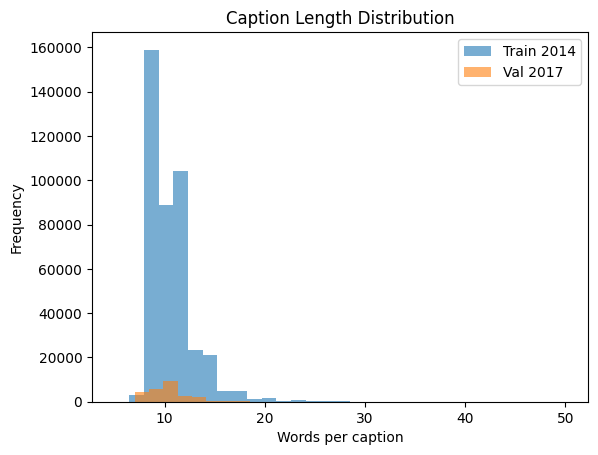

In [84]:
for name, df in [("Train 2014", df_captions_2014), ("Val 2017", df_captions_2017)]:
    # Add a new column 'caption_length' representing word count
    df['caption_length'] = df['caption'].apply(lambda x: len(x.split()))
    
    # Plot histogram for caption lengths
    plt.hist(df['caption_length'], bins=30, alpha=0.6, label=name)

plt.title("Caption Length Distribution")
plt.xlabel("Words per caption")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### **Most Common Words in Captions – Train vs Validation**

In this section, we analyze the **most frequently used words** in the COCO dataset captions for both **Train 2014** and **Val 2017** splits.

- We clean captions by converting to lowercase and keeping only alphabetic words.  
- We count word occurrences and identify the **top N common words**.  
- This helps understand dataset vocabulary and can guide **tokenization and preprocessing** for text-to-image models.


In [85]:
def get_common_words(df, n=20):
    # Combine all captions into a single string and convert to lowercase
    words = " ".join(df['caption']).lower()
    
    # Extract alphabetic words only (remove numbers, punctuation)
    words = re.findall(r'\b[a-z]+\b', words)
    
    # Count occurrences and return the top `n` words
    return Counter(words).most_common(n)

# Get top 20 common words for Train 2014 and Val 2017
common_2014 = get_common_words(df_captions_2014)
common_2017 = get_common_words(df_captions_2017)

# Display top 10 words for validation set
pd.DataFrame(common_2017, columns=["Word", "Count"]).head(10)

Word  Count
0     a  41143
1    on   9079
2    of   8619
3   the   8416
4    in   7662
5  with   6415
6   and   5851
7    is   4207
8    to   3024
9   man   2927

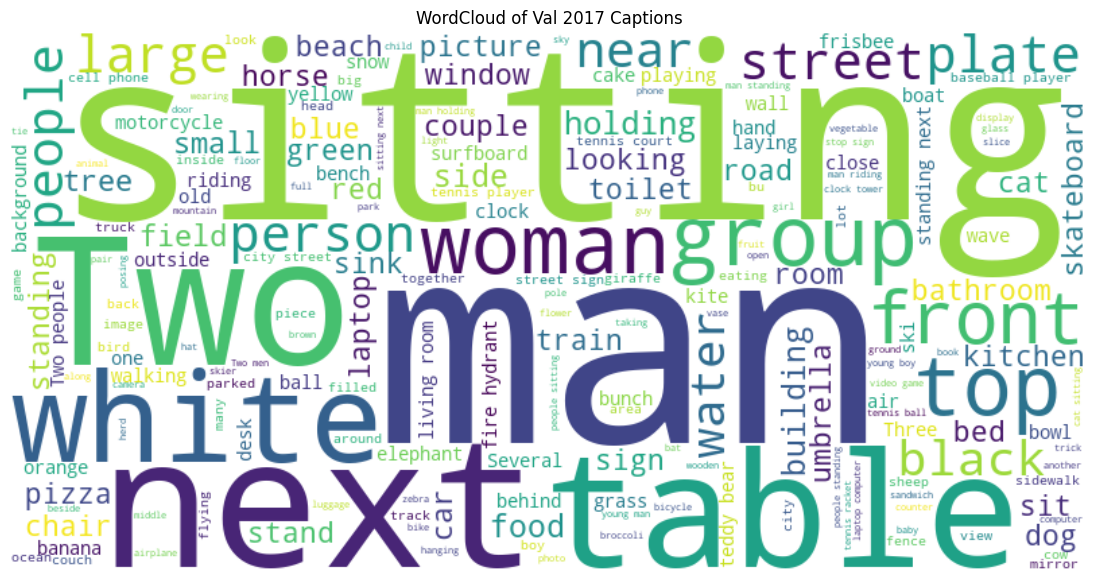

In [86]:
# Combine all captions into a single string
text = " ".join(df_captions_2017['caption'])

# Create WordCloud object
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(text)

# Display the WordCloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axes
plt.title("WordCloud of Val 2017 Captions")
plt.show()

### **Display Random Sample Images with Captions**

This section displays a few **random images from the COCO dataset** along with their corresponding captions.  

- Helps visually verify that captions match the images.  
- Provides insight into image diversity and caption quality.  
- We show samples from both **Train 2014** and **Val 2017** splits.


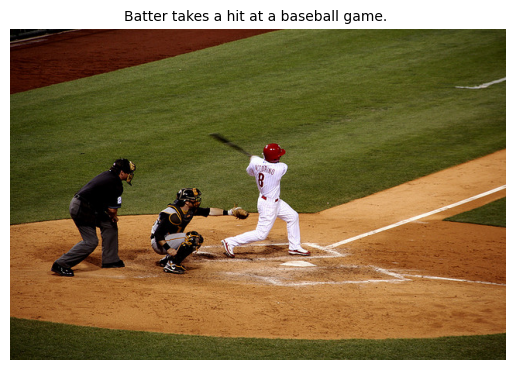

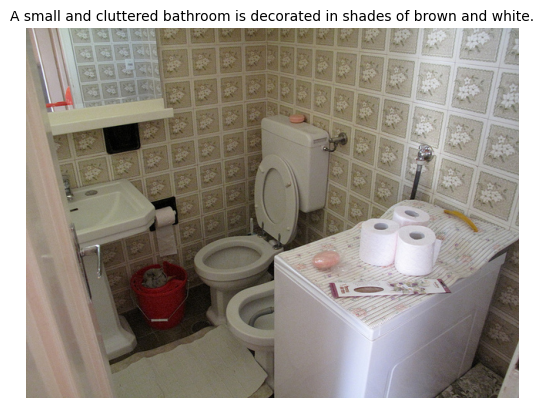

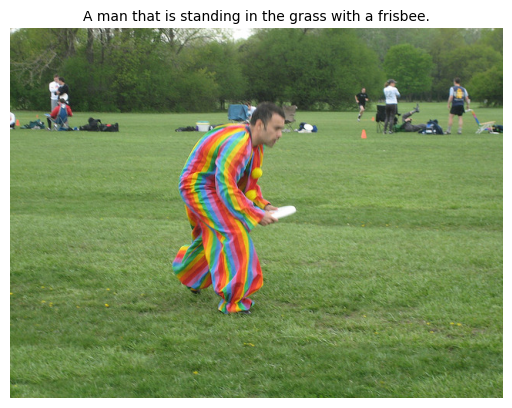

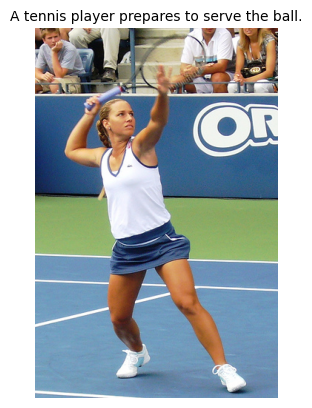

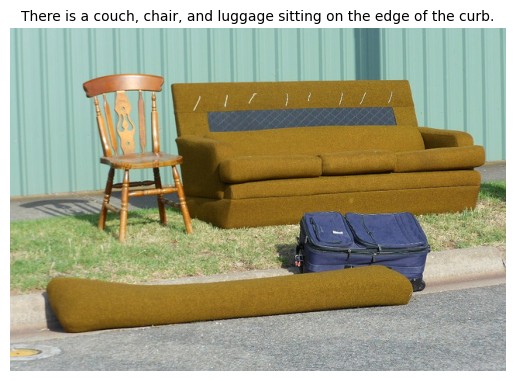

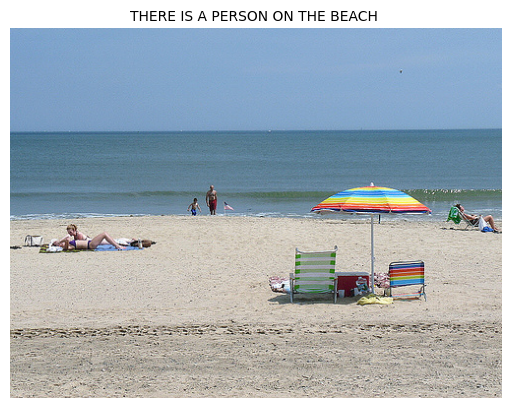

In [87]:
# Directories containing COCO images
image_dir_2014 = "../data/Image_Caption_Dataset/train2014/train2014"
image_dir_2017 = "../data/Image_Caption_Dataset/val2017/val2017"

def show_random_caption(df, image_dir, n_samples=3):
    sample = df.sample(n_samples)  # Randomly select rows
    for _, row in sample.iterrows():
        # Construct image filename based on dataset split
        img_path = os.path.join(
            image_dir,
            f"COCO_train2014_{row['image_id']:012d}.jpg"
        ) if "train2014" in image_dir else os.path.join(
            image_dir,
            f"{row['image_id']:012d}.jpg"
        )

        # Check if image exists, then display
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis("off")  # Hide axes for clean display
            plt.title(row['caption'], fontsize=10)  # Show caption as title
            plt.show()

# Display 3 random samples from Train 2014 and Val 2017
show_random_caption(df_captions_2014, image_dir_2014)
show_random_caption(df_captions_2017, image_dir_2017)

### **Analysis of Object Categories – COCO 2017 Val**

In this section, we analyze the **distribution of object categories** in the COCO 2017 validation dataset.  

- `instances_val2017.json` contains object-level annotations for each image.  
- We count the frequency of each category and visualize the **top categories**.  
- Helps understand **which objects are most common**, which can guide model training or evaluation.


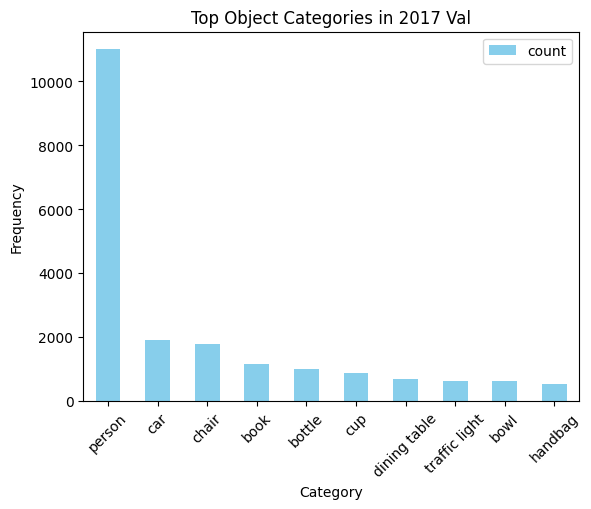

In [88]:
instances_path = "../data/Image_Caption_Dataset/annotations_trainval2017/annotations/instances_val2017.json"

with open(instances_path, "r") as f:
    instances = json.load(f)

df_instances = pd.DataFrame(instances["annotations"])
df_categories = pd.DataFrame(instances["categories"])

# Count frequency of each category_id
category_counts = df_instances["category_id"].value_counts().reset_index()
category_counts.columns = ["category_id", "count"]

# Merge with category names for readability
category_counts = category_counts.merge(df_categories, left_on="category_id", right_on="id")

# Plot top 10 categories by frequency
category_counts.head(10).plot(
    kind="bar",
    x="name",
    y="count",
    title="Top Object Categories in 2017 Val",
    color="skyblue"
)
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [90]:
# Merge captions with instance category IDs
merged = df_captions_2017.merge(
    df_instances[['image_id', 'category_id']],
    on='image_id'
)

# Merge with category names for readability
merged = merged.merge(
    df_categories[['id', 'name']],
    left_on='category_id',
    right_on='id'
)

dog_categories = merged[merged['caption'].str.contains("dog", case=False)]['name'].value_counts()

# Display top 10 categories in images whose captions contain "dog"
dog_categories.head(10)

name
person          988
dog             882
hot dog         362
book            260
car             234
chair           175
bench           170
bottle          136
dining table    112
couch            93
Name: count, dtype: int64

# Downloading the Sequential Storytelling Image Dataset (SSID)

The **Sequential Storytelling Image Dataset (SSID)** is a multimodal dataset that pairs short sequential story texts with corresponding images.  
Each story is split into smaller “storylets,” where each storylet represents one image and its associated sentence.  
You can find the dataset and full documentation on GitHub:  
👉 [https://github.com/zmmalakan/SSID-Dataset](https://github.com/zmmalakan/SSID-Dataset)

---

### Step 1: Download the Dataset

You can **download** the **Dataset** from the Drive Link attached in the **ReadME.md** file of the github.
It has both annotations and images separated in different folders

1. Download the **SSID_Images.zip** and **SSID_Annotations.zip** from the drive link.
2.Extract and move them into:
```
data/SSID-Dataset/
├── SSID_Images/
└── SSID_Annotations/
    ├── SSID_Train.json
    ├── SSID_Validation.json
    └── SSID_Test.json
```
### Step 2: Understanding the Data Structure

* Each JSON file (train/test/val) contains a key called "annotations", which is a list of storylets.
* Here’s an example of one entry:
```JSON
{
  "annotations": [
    [
      {
        "storylet_id": 5887,
        "storytext": "Today I am in my friend's house and he is very happy for me.",
        "youtube_image_id": "2001",
        "album_id": 10856,
        "story_id": 5887,
        "image_order": 1
      },
      {
        "storylet_id": 5888,
        "storytext": "He is telling me about his car.",
        "youtube_image_id": "2002",
        "album_id": 10856,
        "story_id": 5887,
        "image_order": 2
      }
    ]
  ]
}
```

### Field Descriptions

| **Field** | **Description** |
|------------|-----------------|
| `album_id` | Represents the story to which an image belongs (same as `story_id`). |
| `story_id` | Identifier for the complete story sequence. |
| `storylet_id` | Unique ID for each story sentence (one per image). |
| `storytext` | Text describing the specific image in the story sequence. |
| `youtube_image_id` | The filename (image ID) inside the `SSID_Images` folder. |
| `image_order` | Position of this image in the sequence of the story. |



# **Load SSID Dataset JSON Annotations**

In this section, we define paths to the **Sequential Storytelling Image Dataset (SSID)** annotation files.  

- The SSID dataset provides story sequences with corresponding images.  
- Each JSON file contains a key `"annotations"`, which is a **list of storylets**.  
- We separate the dataset into **train, validation, and test** splits.

In [91]:
# Directory containing SSID annotation JSON files
annotations_dir = '../data/SSID_Annotations/SSID_Annotations'

# Full paths to train, validation, and test JSON files
train_json = os.path.join(annotations_dir, "SSID_Train.json")
val_json = os.path.join(annotations_dir, "SSID_Validation.json")
test_json = os.path.join(annotations_dir, "SSID_Test.json")

# Print to verify paths
print("Train JSON exists:", os.path.exists(train_json))
print("Validation JSON exists:", os.path.exists(val_json))
print("Test JSON exists:", os.path.exists(test_json))

Train JSON exists: True
Validation JSON exists: True
Test JSON exists: True


In [92]:
def load_annotations(json_path):
    """Load annotations JSON file."""
    with open(json_path, "r") as f:
        data = json.load(f)
    return data["annotations"]

In [93]:
train_data = load_annotations(train_json)
val_data = load_annotations(val_json)
test_data = load_annotations(test_json)

In [94]:
# Print number of stories in each split
print(f"Train stories: {len(train_data)}")
print(f"Validation stories: {len(val_data)}")
print(f"Test stories: {len(test_data)}")

Train stories: 62500
Validation stories: 3480
Test stories: 3480


In [95]:
train_data

[[{'storylet_id': 5887,
   'storytext': 'Today I am in my friends house and he is very happy for me.',
   'youtube_image_id': '2001',
   'album_id': 10856,
   'story_id': 5887,
   'image_order': 1}],
 [{'storylet_id': 5888,
   'storytext': 'He is telling me about his car.',
   'youtube_image_id': '2002',
   'album_id': 10856,
   'story_id': 5887,
   'image_order': 2}],
 [{'storylet_id': 5889,
   'storytext': "He is telling me about his car's feature.",
   'youtube_image_id': '2003',
   'album_id': 10856,
   'story_id': 5887,
   'image_order': 3}],
 [{'storylet_id': 5890,
   'storytext': 'The car color is white and it looks awesome and beautiful.',
   'youtube_image_id': '2004',
   'album_id': 10856,
   'story_id': 5887,
   'image_order': 4}],
 [{'storylet_id': 5891,
   'storytext': 'Now he is telling me about all doors and seats of the car.',
   'youtube_image_id': '2005',
   'album_id': 10856,
   'story_id': 5887,
   'image_order': 5}],
 [{'storylet_id': 5889,
   'storytext': 'Today I

In [96]:
# Each story in train_data is a list of storylets
# Flatten to create a single list of all storylets
flattened = [item for story in train_data for item in story]

# Convert flattened list to a DataFrame
df = pd.DataFrame(flattened)
df.head()  # Show first few storylets

storylet_id                                          storytext  \
0         5887  Today I am in my friends house and he is very ...   
1         5888                    He is telling me about his car.   
2         5889          He is telling me about his car's feature.   
3         5890  The car color is white and it looks awesome an...   
4         5891  Now he is telling me about all doors and seats...   

  youtube_image_id  album_id  story_id  image_order  
0             2001     10856      5887            1  
1             2002     10856      5887            2  
2             2003     10856      5887            3  
3             2004     10856      5887            4  
4             2005     10856      5887            5

In [97]:
# Filter storylets belonging to story_id 5887
one_story = df[df['story_id'] == 5887].sort_values(by=['image_order'])

# Display storylets in order
one_story

storylet_id                                          storytext  \
0         5887  Today I am in my friends house and he is very ...   
1         5888                    He is telling me about his car.   
2         5889          He is telling me about his car's feature.   
3         5890  The car color is white and it looks awesome an...   
4         5891  Now he is telling me about all doors and seats...   

  youtube_image_id  album_id  story_id  image_order  
0             2001     10856      5887            1  
1             2002     10856      5887            2  
2             2003     10856      5887            3  
3             2004     10856      5887            4  
4             2005     10856      5887            5

In [41]:
len(one_story)

5

## **Visualize a Story with Images and Storylets**

This section allows us to **display an entire story from the SSID dataset** with:

- All images in the story shown in sequence.  
- Story text printed in order below the images.  

This helps verify that the dataset preserves the **temporal and narrative structure** of stories, which is crucial for generating images from sequential paragraphs.


In [42]:
def display_random_story(df, image_dir):
    """Display a random story with its images and captions."""

    n = len(df)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    fig.suptitle(f"Story ID: {df['story_id'].iloc[0]}  |  Album ID: {df['album_id'].iloc[0]}",
                 fontsize=14, fontweight='bold')

    if n == 1:
        axes = [axes]  # handle single image case

    for i, (idx, row) in enumerate(df.iterrows()):
        image_path = os.path.join(image_dir, f"{row['youtube_image_id']}.jpg")

        if os.path.exists(image_path):
            img = Image.open(image_path).convert("RGB")
            axes[i].imshow(img)
        else:
            axes[i].imshow(Image.new('RGB', (224, 224), color='gray'))
            axes[i].set_title("Missing Image", fontsize=10, color='red')

        axes[i].set_title(f"Order {row['image_order']}", fontsize=10)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

    # Display story text below
    print("Full Story:")
    for _, row in df.iterrows():
        print(f"{row['image_order']}. {row['storytext']}")

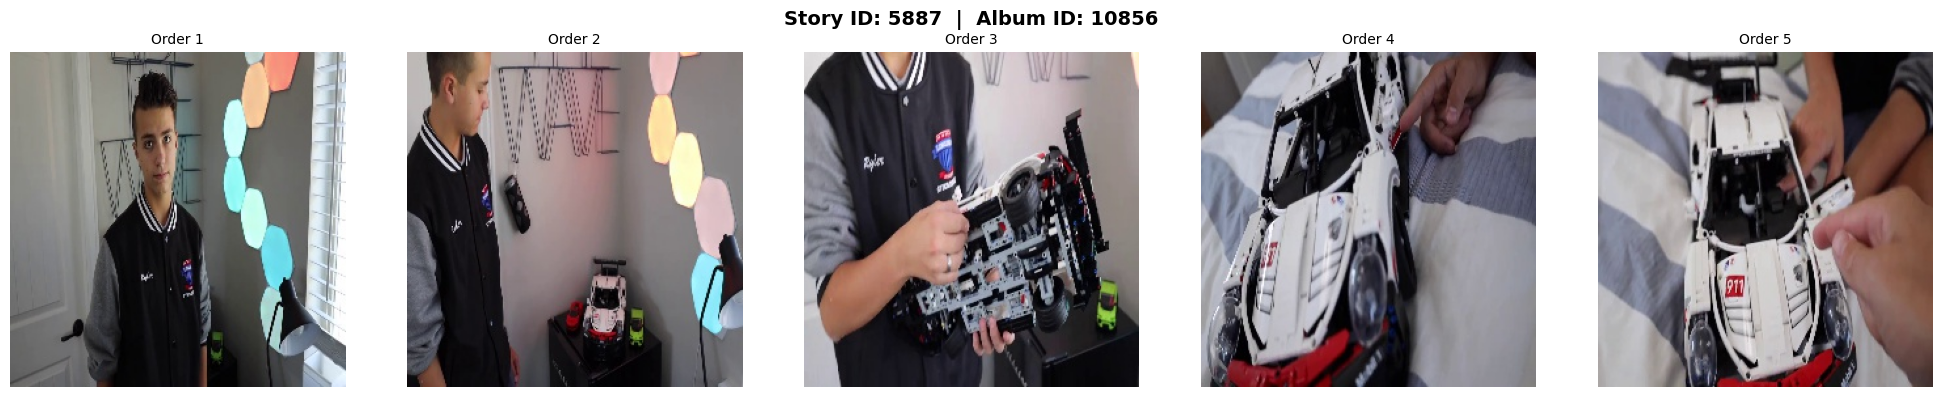

Full Story:
1. Today I am in my friends house and he is very happy for me.
2. He is telling me about his car.
3. He is telling me about his car's feature.
4. The car color is white and it looks awesome and beautiful.
5. Now he is telling me about all doors and seats of the car.


In [43]:
# Visualize the story stored in `one_story` with its images
display_random_story(one_story, '../data/SSID_Images/SSID_Images')

## **Inspect Another Example Story**

To get a better sense of **story variety and dataset quality**, we display another story from the SSID dataset.

- Extract all storylets of a specific story (`story_id = 5901`).  
- Sort storylets by `image_order` to preserve narrative sequence.  
- Visualize images and print the story text in order.


In [46]:
second_story = df[df['story_id'] == 5901].sort_values(by=['image_order'])

# Display the storylets in a DataFrame
second_story

storylet_id                                          storytext  \
35         5901  Mom is excitedly packing all the suitcases for...   
36         5902  Dad is talking to his son about the long great...   
37         5903  Daughter is very excited to hear about all the...   
38         5904  Mom is prepping the car by removing the van se...   
39         5905  Dad is checking and rechecking all the doors b...   

   youtube_image_id  album_id  story_id  image_order  
35             2006     10861      5901            1  
36             2007     10861      5901            2  
37             2008     10861      5901            3  
38             2009     10861      5901            4  
39             2010     10861      5901            5

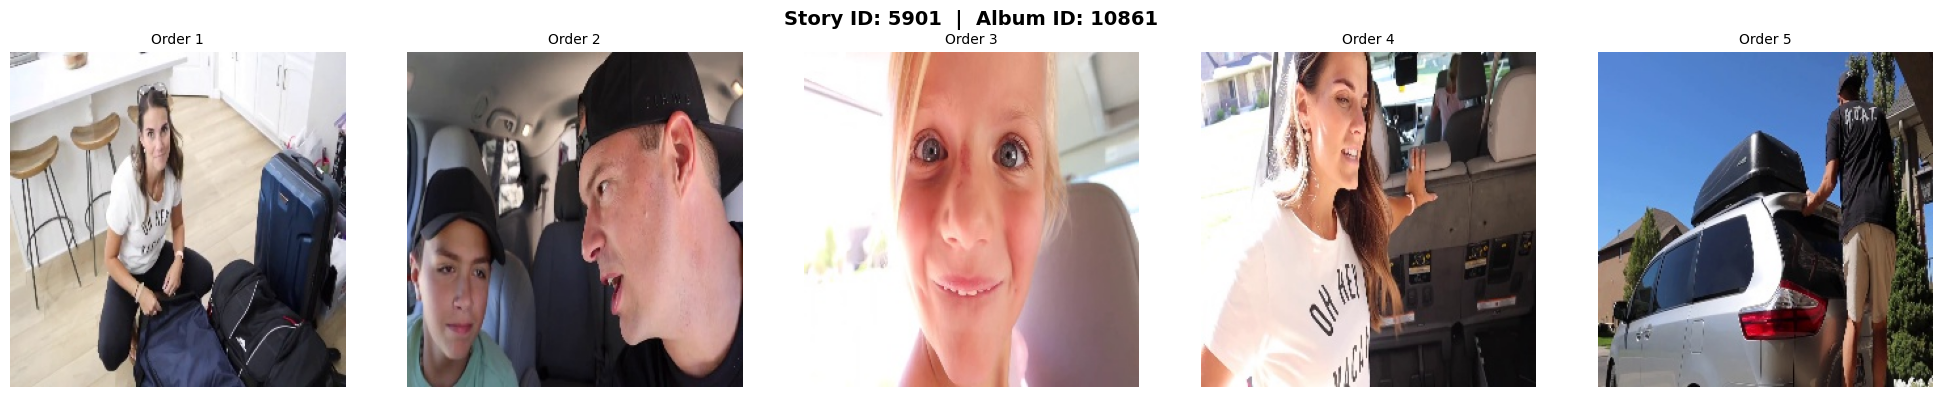

Full Story:
1. Mom is excitedly packing all the suitcases for the family weeklong car trip up north.
2. Dad is talking to his son about the long great trip ahead of us and reminding him to get along.
3. Daughter is very excited to hear about all the adventures that the family is embarking on.
4. Mom is prepping the car by removing the van seats for the long family vacation.
5. Dad is checking and rechecking all the doors before heading on the road for the family car trip.


In [47]:
display_random_story(second_story, '../data/SSID_Images/SSID_Images')

# **EDA: Flatten and Combine SSID Dataset**

In this section, we **load, flatten, and combine all splits** of the SSID dataset for exploratory data analysis (EDA).  

- Each JSON file contains nested lists of stories, where each story is a list of storylets.  
- We flatten these lists so that each **storylet becomes one row** in a DataFrame.  
- We also add a `split` column to indicate whether the storylet belongs to **train, validation, or test**.  
- Finally, we concatenate all splits into a single DataFrame for unified analysis.


In [72]:
def load_annotations(json_path, split_name):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # Flatten list of lists into one list of storylets
    flat_data = [storylet for story in data['annotations'] for storylet in story]
    df = pd.DataFrame(flat_data)
    df['split'] = split_name
    return df

df_train = load_annotations(train_json, 'train')
df_val = load_annotations(val_json, 'val')
df_test = load_annotations(test_json, 'test')

# Combine all splits
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
df_all.head()

storylet_id                                          storytext  \
0         5887  Today I am in my friends house and he is very ...   
1         5888                    He is telling me about his car.   
2         5889          He is telling me about his car's feature.   
3         5890  The car color is white and it looks awesome an...   
4         5891  Now he is telling me about all doors and seats...   

  youtube_image_id  album_id  story_id  image_order  split  
0             2001     10856      5887            1  train  
1             2002     10856      5887            2  train  
2             2003     10856      5887            3  train  
3             2004     10856      5887            4  train  
4             2005     10856      5887            5  train

In [73]:
print("Dataset Overview:")
print(f"Train samples: {len(df_train)}")
print(f"Validation samples: {len(df_val)}")
print(f"Test samples: {len(df_test)}")
print(f"Total storylets: {len(df_all)}")

print(f"Unique stories: {df_all['story_id'].nunique()}")
print(f"Unique albums: {df_all['album_id'].nunique()}")


Dataset Overview:
Train samples: 62500
Validation samples: 3480
Test samples: 3480
Total storylets: 69460
Unique stories: 13892
Unique albums: 3473


### **EDA: Distribution of Story Lengths**

In this section, we analyze the **number of storylets (paragraph-image pairs) per story** in the SSID dataset.

- Each story consists of multiple storylets, and story length varies across stories.  
- Understanding story length distribution is important for **modeling sequential dependencies** in paragraph-to-image generation.


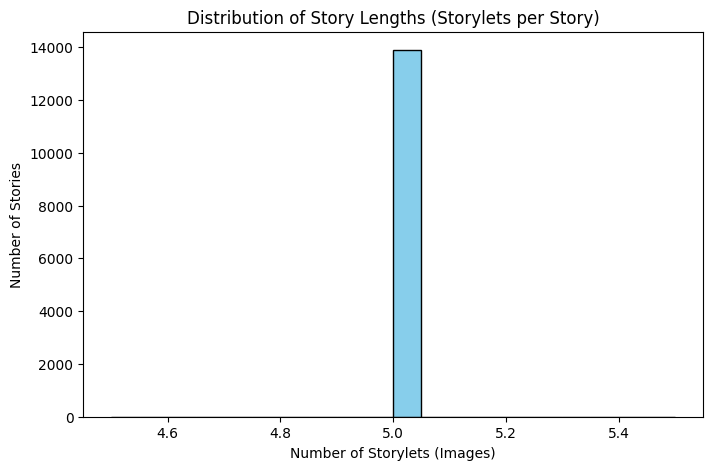

Average story length: 5.00
Max story length: 5


In [98]:
# Count number of storylets per story
story_lengths = df_all.groupby('story_id').size()

# Plot histogram of story lengths
plt.figure(figsize=(8,5))
plt.hist(story_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Story Lengths (Storylets per Story)")
plt.xlabel("Number of Storylets (Images)")
plt.ylabel("Number of Stories")
plt.show()

# Compute summary statistics
print(f"Average story length: {story_lengths.mean():.2f}")
print(f"Max story length: {story_lengths.max()}")


### **EDA: Distribution of Storylet Text Lengths**

In this section, we analyze the **length of each storylet in terms of words**.  

- Each storylet corresponds to a paragraph or sentence paired with an image.  
- Understanding the distribution of storylet text lengths helps in:
  - Designing tokenization strategies for text-to-image models.
  - Setting appropriate limits for text encoding.


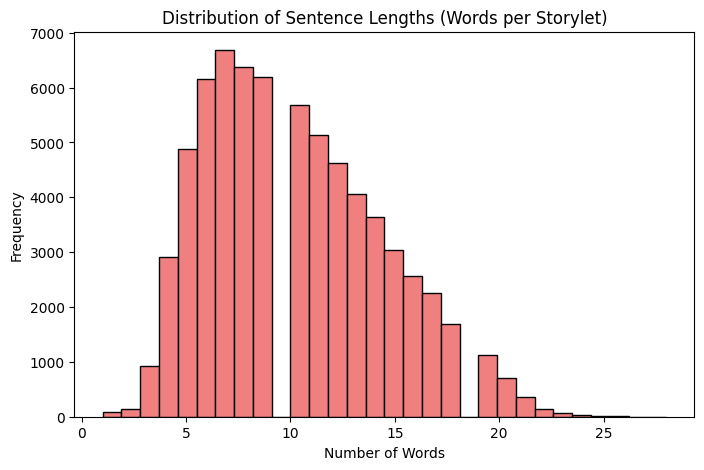

count    69460.000000
mean        10.163418
std          4.202161
min          1.000000
25%          7.000000
50%         10.000000
75%         13.000000
max         28.000000
Name: text_length, dtype: float64


In [99]:
# Compute storylet text length (words per storylet)
df_all['text_length'] = df_all['storytext'].apply(lambda x: len(x.split()))

# Plot histogram of storylet text lengths
plt.figure(figsize=(8,5))
plt.hist(df_all['text_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title("Distribution of Sentence Lengths (Words per Storylet)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Display summary statistics
print(df_all['text_length'].describe())


### **EDA: Most Frequent Words in SSID Storylets**

In this section, we analyze the **most common words** across all storylets in the SSID dataset.

- Helps understand **dataset vocabulary and common themes**.  
- Can guide preprocessing steps such as **stopword removal**, **embedding coverage**, or **keyword-based generation**.


In [76]:
all_text = " ".join(df_all['storytext']).lower()
# Keep only alphabetic words
words = re.findall(r'\b[a-z]+\b', all_text)
common_words = Counter(words).most_common(20)

# Display top 20 words as a DataFrame
pd.DataFrame(common_words, columns=['Word', 'Count'])


Word  Count
0    the  58185
1      a  31758
2     to  22201
3     is  16752
4    and  16468
5     in  13869
6     of  12431
7     on   8424
8    are   8295
9   with   7444
10  they   6785
11    he   6722
12   man   6376
13   her   6228
14   his   6044
15    at   5443
16   for   5323
17   she   5231
18   was   5161
19    it   4323

### **EDA: WordCloud of SSID Storylets**

In this section, we create a **WordCloud** to visualize the most frequent words in the SSID dataset.

- Provides a **quick visual overview of dataset vocabulary**.  
- Highlights common themes and frequently occurring words across all storylets.  
- Complementary to the top-words frequency table for textual analysis.


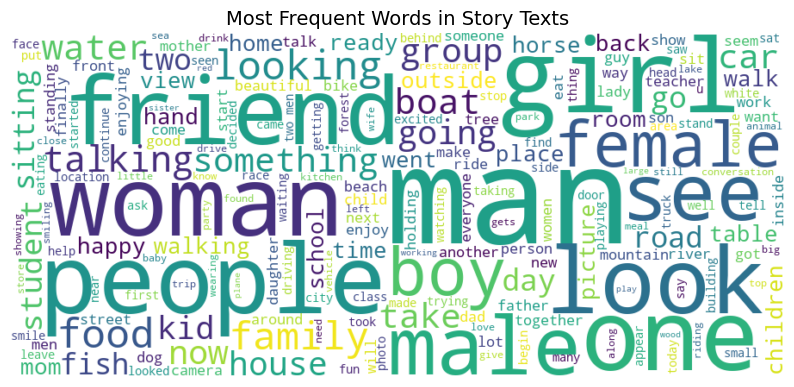

In [77]:
# Combine all storylet text into one string
text = " ".join(df_all['storytext'])

# Generate WordCloud
wordcloud = WordCloud(width=900, height=400, background_color='white').generate(text)

# Display the WordCloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Story Texts", fontsize=14)
plt.show()